<a href="https://colab.research.google.com/github/mferuscomelo/fall-detection/blob/main/fall_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from https://arxiv.org/ftp/arxiv/papers/1911/1911.11976.pdf

In [1]:
# If the Notebook is running in Colab, clone the git repo
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/mferuscomelo/fall-detection.git

Cloning into 'fall-detection'...
remote: Enumerating objects: 13681, done.
remote: Total 13681 (delta 0), reused 0 (delta 0), pack-reused 13681
Receiving objects: 100% (13681/13681), 489.62 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (4458/4458), done.
Checking out files: 100% (4553/4553), done.


In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import plot_confusion_matrix

In [3]:
dataset_dir = "/content/fall-detection/dataset"

adl_filepaths = []
fall_filepaths = []

# Go through dataset and sort files into ADL and Fall actions
for subdir, dirs, files in os.walk(dataset_dir):
  for file in files:
    # Make sure that only csv files are included
    if "csv" not in file:
      continue

    path = os.path.join(subdir, file)

    if file[0] == "D":
      adl_filepaths.append(path)
    elif file[0] == "F":
      fall_filepaths.append(path)

In [4]:
def convert_data(data_bits: list, range: int, resolution: int) -> list:
  """Convert bits into gravity or angular velocity

  Equation = [(2 * Range) / ( 2 ** Resolution)] * Data

  Args:
    data_bits (list): List of numbers to convert
    range (int): The range of the sensor
    resolution (int): The resolution of the sensor

  Returns:
    list: Converted list
  """
  data_converted = data_bits * ((2 * range) / (2 ** resolution))
  return data_converted

In [5]:
def mean(data):
  """Calculate the mean for an array of values

  Args:
    data (list): List of numbers

  Returns:
    float: Mean of list
  """
  return np.mean(data)

def std(data: list) -> float:
  """Calculate the standard deviation for an array of values

  Args:
    data (list): List of numbers

  Returns:
    float: Standard deviation of list
  """
  return np.std(data)

def extract_features(df: pd.DataFrame) -> pd.DataFrame:
  """Calculate features for a dataframe

  This function calulates the following features for each column of the dataframe  
  - maximum amplitude
  - minimum amplitude
  - mean amplitude
  - variance (standard deviation)
  - kurtosis
  - skewness

  Args:
    df (DataFrame): Dataframe of a file
  
  Returns:
    DataFrame: Generated features dataframe (1 row, 55 columns). 6 features * 3 axis * 3 sensors and 1 class (0 -> ADL, 1 -> Fall)
  """
  features = []
  col_names = []

  # Generate column names
  for sensor_name in ["acc1_x", "acc1_y", "acc1_z", "gyro_x", "gyro_y", "gyro_z", "acc2_x", "acc2_y", "acc2_z"]:
    for variable_type in ["max_amp", "min_amp", "mean_amp", "variance", "kurtosis", "skewness"]:
        col_names.append(f"{sensor_name}_{variable_type}")

  row = []

  # Calculate the 6 features and add them to a row
  for col in df:
    col_data = df[col]

    row.append(max(col_data)) # maximum amplitude
    row.append(min(col_data)) # minimum amplitude
    row.append(mean(col_data)) # mean amplitude
    row.append(std(col_data)) # variance
    row.append(kurtosis(col_data)) # kurtosis
    row.append(skew(col_data)) # skewness

  features.append(row)

  features_df = pd.DataFrame(features, columns=col_names)

  return features_df

In [6]:
col_names = ["acc1_x", "acc1_y", "acc1_z", "gyro_x", "gyro_y", "gyro_z", "acc2_x", "acc2_y", "acc2_z"]

def calc_features_df(file_path: str, class_num: int):
  """Calculate features for a sample file

  Args:
    file_path (str): Path of the file
    class_num (int): 0 -> ADL, 1 -> Fall
  
  Returns:
    DataFrame: Generated features dataframe (1 row, 55 columns). 6 features * 3 axis * 3 sensors and 1 class (0 -> ADL, 1 -> Fall)
  """
  df = pd.read_csv(file_path, names=col_names, header=None)

  for axis in ["x", "y", "z"]:
    df[f"acc1_{axis}"] = convert_data(df[f"acc1_{axis}"], 16, 13)
    df[f"acc2_{axis}"] = convert_data(df[f"acc2_{axis}"], 8, 14)
    df[f"gyro_{axis}"] = convert_data(df[f"gyro_{axis}"], 2000, 16)

  features_df = extract_features(df)
  features_df["class"] = np.full(len(features_df), class_num)

  return features_df

In [7]:
adl_df_list = []
fall_df_list = []

for file in adl_filepaths:
  features_df = calc_features_df(file, 0)
  adl_df_list.append(features_df)

for file in fall_filepaths:
  features_df = calc_features_df(file, 1)
  fall_df_list.append(features_df)

adl_df = pd.concat(adl_df_list, sort=False, ignore_index=True)
fall_df = pd.concat(fall_df_list, sort=False, ignore_index=True)

In [8]:
print(len(adl_df), "rows,", len(adl_df.columns), "cols")
adl_df.head()

2707 rows, 55 cols


,acc1_x_max_amp,acc1_x_min_amp,acc1_x_mean_amp,acc1_x_variance,acc1_x_kurtosis,acc1_x_skewness,acc1_y_max_amp,acc1_y_min_amp,acc1_y_mean_amp,acc1_y_variance,acc1_y_kurtosis,acc1_y_skewness,acc1_z_max_amp,acc1_z_min_amp,acc1_z_mean_amp,acc1_z_variance,acc1_z_kurtosis,acc1_z_skewness,gyro_x_max_amp,gyro_x_min_amp,gyro_x_mean_amp,gyro_x_variance,gyro_x_kurtosis,gyro_x_skewness,gyro_y_max_amp,gyro_y_min_amp,gyro_y_mean_amp,gyro_y_variance,gyro_y_kurtosis,gyro_y_skewness,gyro_z_max_amp,gyro_z_min_amp,gyro_z_mean_amp,gyro_z_variance,gyro_z_kurtosis,gyro_z_skewness,acc2_x_max_amp,acc2_x_min_amp,acc2_x_mean_amp,acc2_x_variance,acc2_x_kurtosis,acc2_x_skewness,acc2_y_max_amp,acc2_y_min_amp,acc2_y_mean_amp,acc2_y_variance,acc2_y_kurtosis,acc2_y_skewness,acc2_z_max_amp,acc2_z_min_amp,acc2_z_mean_amp,acc2_z_variance,acc2_z_kurtosis,acc2_z_skewness,class
0,0.421875,-0.296875,0.059663,0.045718,12.925532,-0.378106,-0.035156,-1.535156,-0.966224,0.129907,15.638643,2.780268,0.070312,-1.480469,-0.251025,0.203975,5.246669,-2.083055,123.535156,-154.907227,-3.347117,27.439918,7.394057,-1.207600,50.720215,-30.151367,0.737101,7.470424,11.881767,1.495045,19.470215,-25.634766,-0.469818,3.452563,12.876844,-1.257396,0.399414,-0.244141,0.059824,0.043060,13.170352,-0.379121,-0.022461,-1.448242,-0.934950,0.125440,16.594749,3.071666,0.196289,-1.362305,-0.118729,0.206615,5.414156,-2.124700,0
1,0.175781,-0.148438,0.003727,0.041878,-0.405562,-0.402294,-0.281250,-1.136719,-0.800783,0.255579,-1.171908,0.807548,-0.019531,-1.121094,-0.451126,0.409472,-1.540269,-0.536807,68.420410,-119.079590,-2.756144,23.441687,7.352033,-1.561751,20.385742,-23.742676,1.125336,4.586274,5.466133,0.661590,17.211914,-13.549805,-0.222778,3.047032,4.345508,0.728488,0.157227,-0.146484,0.004879,0.042375,-0.381281,-0.531344,-0.258789,-1.122070,-0.769619,0.256546,-1.188265,0.801483,0.074219,-0.989258,-0.321789,0.416300,-1.541195,-0.539717,0
2,0.179688,-0.234375,0.032087,0.049472,0.115240,-0.736720,-0.515625,-1.066406,-0.863581,0.153877,-1.095794,0.730458,-0.003906,-1.035156,-0.432575,0.346077,-1.492905,-0.472463,38.269043,-73.486328,-2.996343,15.026336,3.593749,-1.141877,22.216797,-20.080566,1.273168,4.313856,5.476907,-0.083322,8.605957,-11.108398,-0.443370,2.286477,4.237953,-0.439011,0.180664,-0.213867,0.032501,0.048927,-0.009212,-0.775033,-0.492188,-1.018555,-0.831589,0.155802,-1.120991,0.720021,0.093750,-0.908203,-0.301622,0.350323,-1.496325,-0.475291,0
3,0.359375,-0.464844,-0.005449,0.099932,1.378768,-0.091140,-0.562500,-1.890625,-0.955220,0.169461,2.653359,-1.041447,0.039062,-0.910156,-0.372905,0.134276,0.293555,-0.458069,92.468262,-73.181152,-2.747046,12.535762,5.469367,0.533099,71.044922,-126.953125,-4.901978,27.573952,4.872842,-1.741771,28.564453,-58.227539,-2.444189,11.674463,3.938409,-1.231909,0.341797,-0.458008,-0.004684,0.096538,1.341889,-0.120091,-0.529297,-1.819336,-0.921849,0.164296,2.434596,-0.979196,0.159180,-0.798828,-0.242807,0.136346,0.294683,-0.474218,0
4,1.066406,-0.191406,0.431110,0.445005,-1.789584,0.303376,0.082031,-0.222656,-0.067061,0.068114,-1.300010,0.329418,0.914062,0.035156,0.591183,0.296754,-1.597817,-0.510229,33.325195,-21.789551,-3.310318,5.602548,7.371385,1.471793,80.017090,-82.275391,1.035970,23.072384,3.717317,0.071164,18.066406,-19.531250,-0.430044,4.479774,4.113505,0.065123,1.033203,-0.184570,0.421455,0.425635,-1.786234,0.304783,0.081055,-0.219727,-0.064331,0.066422,-1.356985,0.361699,1.026367,0.171875,0.728109,0.304240,-1.603471,-0.510901,0


In [9]:
print(len(fall_df), "rows,", len(fall_df.columns), "cols")
fall_df.head()

1798 rows, 55 cols


,acc1_x_max_amp,acc1_x_min_amp,acc1_x_mean_amp,acc1_x_variance,acc1_x_kurtosis,acc1_x_skewness,acc1_y_max_amp,acc1_y_min_amp,acc1_y_mean_amp,acc1_y_variance,acc1_y_kurtosis,acc1_y_skewness,acc1_z_max_amp,acc1_z_min_amp,acc1_z_mean_amp,acc1_z_variance,acc1_z_kurtosis,acc1_z_skewness,gyro_x_max_amp,gyro_x_min_amp,gyro_x_mean_amp,gyro_x_variance,gyro_x_kurtosis,gyro_x_skewness,gyro_y_max_amp,gyro_y_min_amp,gyro_y_mean_amp,gyro_y_variance,gyro_y_kurtosis,gyro_y_skewness,gyro_z_max_amp,gyro_z_min_amp,gyro_z_mean_amp,gyro_z_variance,gyro_z_kurtosis,gyro_z_skewness,acc2_x_max_amp,acc2_x_min_amp,acc2_x_mean_amp,acc2_x_variance,acc2_x_kurtosis,acc2_x_skewness,acc2_y_max_amp,acc2_y_min_amp,acc2_y_mean_amp,acc2_y_variance,acc2_y_kurtosis,acc2_y_skewness,acc2_z_max_amp,acc2_z_min_amp,acc2_z_mean_amp,acc2_z_variance,acc2_z_kurtosis,acc2_z_skewness,class
0,6.003906,-0.292969,0.275811,0.259537,164.832933,10.260540,4.054688,-1.031250,-0.066996,0.585806,1.583436,-0.199466,0.355469,-3.648438,-0.841708,0.334044,6.892251,-0.242353,144.348145,-136.413574,-6.757751,16.221153,15.368589,-1.224756,199.401855,-74.035645,3.573263,23.449084,28.466147,4.140991,54.565430,-277.465820,-1.567688,20.246479,87.527160,-8.249226,5.902344,-0.368164,0.263658,0.248294,173.100772,10.415803,3.961914,-0.983398,-0.050113,0.573274,1.530172,-0.227005,0.484375,-3.638672,-0.717681,0.339142,7.370668,-0.306427,1
1,6.136719,-2.566406,0.020382,0.228121,255.073270,11.208269,14.105469,-1.976562,-0.097384,0.690142,59.824560,2.597900,0.480469,-10.320312,-0.852241,0.440634,79.104233,-4.248651,69.763184,-434.265137,-7.932129,35.345526,34.062874,-4.870472,218.383789,-501.831055,-0.297465,23.656827,87.994191,-3.453223,30.639648,-198.242188,-1.732585,10.746660,57.908827,-4.951552,6.921875,-3.360352,0.017556,0.231203,337.148139,12.045672,7.999023,-1.802734,-0.081142,0.643193,8.150666,0.246633,0.614258,-8.000000,-0.727404,0.430105,36.822471,-2.680758,1
2,2.882812,-1.425781,0.416174,0.362908,3.410346,0.287825,1.339844,-2.468750,-0.222470,0.644518,-1.394185,-0.417339,0.312500,-2.707031,-0.633949,0.311106,0.795537,0.137313,73.852539,-196.716309,-5.626302,20.393727,24.824154,-3.382730,208.435059,-152.099609,5.482524,35.279882,10.588585,2.411491,86.669922,-259.155273,-3.673055,31.080255,25.578951,-4.390708,2.745117,-1.350586,0.394169,0.344972,3.844597,0.378902,1.301758,-2.388672,-0.204344,0.630218,-1.409918,-0.417611,0.428711,-2.585938,-0.506692,0.315142,0.815443,0.121216,1
3,4.625000,-1.191406,0.244896,0.307846,54.631358,4.992116,4.664062,-1.746094,-0.311076,0.628994,2.319523,0.280089,0.226562,-4.117188,-0.700581,0.450757,2.655985,-0.346917,91.552734,-252.685547,-5.923930,24.937199,12.768317,-2.040739,149.169922,-335.327148,-0.783834,31.193918,13.668453,0.525065,61.767578,-334.777832,-4.105591,27.395714,42.738269,-5.713379,4.525391,-1.596680,0.232581,0.300718,64.309525,5.502186,4.925781,-1.650391,-0.290271,0.617273,2.689810,0.321610,0.366211,-4.045898,-0.576668,0.456998,2.784133,-0.379651,1
4,4.875000,-9.496094,-0.056591,0.277691,483.682379,-11.306267,5.296875,-6.003906,-0.493408,0.495053,22.771246,-1.259940,1.277344,-8.593750,-0.766283,0.490136,32.906190,-2.553098,95.520020,-466.796875,-6.503113,33.187867,24.880977,-3.001657,649.780273,-171.691895,0.724731,30.947070,110.939272,5.389897,134.277344,-132.019043,0.602132,16.135119,28.527772,2.276607,5.191406,-8.000000,-0.059038,0.269101,323.640431,-5.664243,5.520508,-5.711914,-0.465248,0.490411,23.878453,-0.918998,1.188477,-6.956055,-0.643659,0.493000,23.083702,-2.167505,1


In [13]:
df = pd.concat([adl_df, fall_df], sort=False, ignore_index=True) # merge the ADL and Fall dataframes
inputs = df.drop(columns=["class"])
classes = df["class"]

In [31]:
random_seed = 42

kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed) # 10-fold cross-validation

clf = svm.SVC(kernel='poly', degree=2) # create a Support Vector Machine (SVM) classifier with a quadratic kernel function

for train, test in kfold.split(df):
  train_df = df.iloc[train]
  test_df = df.iloc[test]

  x_train = train_df.drop(columns=["class"])
  y_train = train_df["class"]

  x_test = test_df.drop(columns=["class"])
  y_test = test_df["class"]

  clf = clf.fit(x_train, y_train)

scores = cross_val_score(clf, inputs, classes, cv=10)
print(f"Avg score: {np.mean(scores)}")

Avg score: 0.9491781226903179


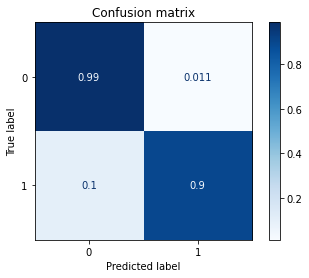

In [26]:
# Calculate the confusion matrix
matrix = plot_confusion_matrix(clf, inputs, classes, cmap=plt.cm.Blues, normalize='true') # should be x_test and y_test
plt.title('Confusion matrix')
plt.show(matrix)
plt.show()